<a href="https://colab.research.google.com/github/thaitruong018/e_commerce_analysis/blob/main/7_Sales_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up

In [18]:
# connect to gg drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
# improt libraries
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import statsmodels.tsa.api as smt

In [20]:
# define a func to load in original dataframe without scaling applied
def load_original_df():
  
  original_df = pd.read_csv(os.path.join(path,'df_order_items_products_customers.csv'))
  original_df = original_df[original_df['order_status']=='delivered'].reset_index(drop=True)
  original_df = original_df[['order_purchase_timestamp','quantity','price']].copy()
  original_df.rename(columns={'order_purchase_timestamp':'date'},inplace=True)
  original_df['sales'] = round(original_df['quantity']*original_df['price'])
  
  original_df['date'] = pd.to_datetime(original_df['date'])
  original_df['date'] = original_df['date'].dt.to_period('M')
  original_df = original_df.groupby('date')['sales'].sum().reset_index()
  original_df['date'] = original_df['date'].dt.strftime('%Y-%m-01')
  original_df['date'] = pd.to_datetime(original_df['date'])
  return original_df

In [21]:
# path to data
path = '/content/gdrive/MyDrive/brazilian_ecommerce'

## Data

In [22]:
# read data
df_orders = pd.read_csv(os.path.join(path,'df_order_items_products_customers.csv'))
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,quantity,seller_id,shipping_limit_date,price,freight_value,product_category_name,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR
1,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,f293394c72c9b5fafd7023301fc21fc2,1,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR
2,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,moveis_decoracao,f922896769e9517ea3c630f3c8de86d0,96832,santa cruz do sul,RS
3,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,c1488892604e4ba5cff5b4eb4d595400,1,1554a68530182680ad5c8b042c3ab563,2016-10-26 16:35:46,39.99,11.80,moveis_decoracao,0ecf7f65b5ff3b9e61b637e59f495e0a,30411,belo horizonte,MG
4,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,c1488892604e4ba5cff5b4eb4d595400,2,1554a68530182680ad5c8b042c3ab563,2017-01-13 00:37:18,38.50,15.56,moveis_decoracao,853ba75a0b423722ccf270eea3b4cfe4,21843,rio de janeiro,RJ


In [23]:
# using only delivered status
df_orders = df_orders[df_orders['order_status']=='delivered'].reset_index(drop=True)
# using necessary columns for further prediction
sales_data = df_orders[['order_purchase_timestamp','quantity','price']].copy()
# rename col
sales_data.rename(columns={'order_purchase_timestamp':'date'},inplace=True)
# calculate sales
sales_data['sales'] = sales_data['quantity']*sales_data['price']
sales_data.head()

,date,quantity,price,sales
0,2016-10-04,1,39.99,39.99
1,2016-10-10,1,39.99,39.99
2,2017-01-09,2,38.50,77.00
3,2017-01-14,1,38.50,38.50
4,2017-01-17,1,38.50,38.50


In [24]:
# overall info
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100196 entries, 0 to 100195
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      100196 non-null  object 
 1   quantity  100196 non-null  int64  
 2   price     100196 non-null  float64
 3   sales     100196 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.1+ MB


In [25]:
# define a dataframe where each row represents total sales
def monthly_sales(data):
  monthly_data = data.copy()
  monthly_data['date'] = pd.to_datetime(monthly_data['date'])
  monthly_data['date'] = monthly_data['date'].dt.to_period('M')
  monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
  monthly_data['date'] = monthly_data['date'].dt.strftime('%Y-%m-01')
  monthly_data['date'] = pd.to_datetime(monthly_data.date)
  return monthly_data
monthly_df = monthly_sales(sales_data)
monthly_df.head()

,date,sales
0,2016-09-01,134.97
1,2016-10-01,40325.11
2,2016-12-01,10.90
3,2017-01-01,111798.36
4,2017-02-01,234223.40


In [26]:
# Average monthly sales
# Overall
avg_monthly_sales = monthly_df['sales'].mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df['sales'][-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")

Overall average monthly sales: $574847.7439130535
Last 12 months average monthly sales: $848964.250000018


In [27]:
# define a func to plot monthly sales
def time_plot(data, x_col, y_col, title):
  plt.figure(figsize=(15,5))
  sns.lineplot(x_col, y_col, data=data, color='mediumblue', label='Total Sales')

  second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
  second.date = pd.to_datetime(second.date, format='%Y')
  sns.lineplot((second.date+ datetime.timedelta(6*365/12)), y_col, data=second,  color='red', label='Mean Sales')   

  plt.xlabel("Date")
  plt.ylabel("Sales")
  plt.title(title)

  sns.despine()
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


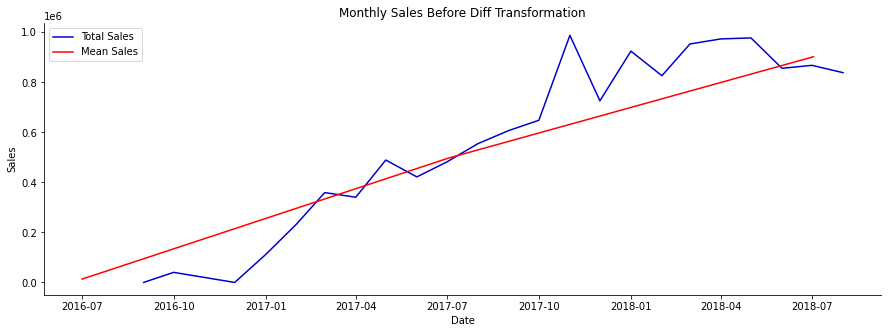

In [28]:
# plot montly sales before transformation
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [29]:
# define a func to calculate differences
def get_diff(data):
  data['sales_diff'] = data.sales.diff()
  data = data.dropna()
  return data
stationary_df = get_diff(monthly_df)
stationary_df.head()

,date,sales,sales_diff
1,2016-10-01,40325.11,40190.14
2,2016-12-01,10.90,-40314.21
3,2017-01-01,111798.36,111787.46
4,2017-02-01,234223.40,122425.04
5,2017-03-01,359198.85,124975.45


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


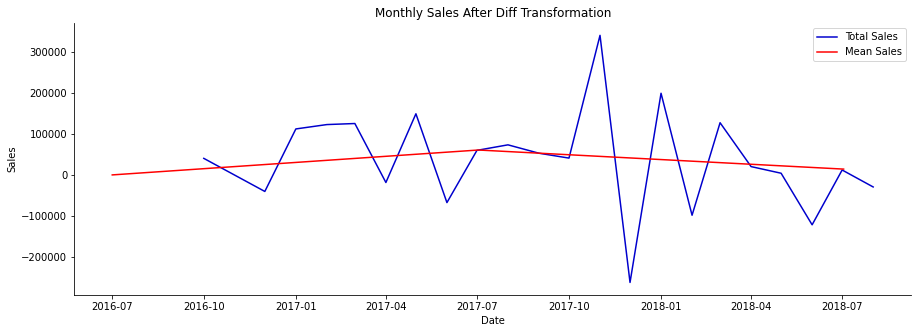

In [30]:
# plot monthly sales after transformation
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

In [31]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,7):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
        
    return supervised_df
model_df = generate_supervised(stationary_df)
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,2017-05-01,489338.25,148668.57,-18529.17,124975.45,122425.04,111787.46,-40314.21,40190.14
1,2017-06-01,421923.37,-67414.88,148668.57,-18529.17,124975.45,122425.04,111787.46,-40314.21
2,2017-07-01,481604.52,59681.15,-67414.88,148668.57,-18529.17,124975.45,122425.04,111787.46
3,2017-08-01,554699.70,73095.18,59681.15,-67414.88,148668.57,-18529.17,124975.45,122425.04
4,2017-09-01,607399.67,52699.97,73095.18,59681.15,-67414.88,148668.57,-18529.17,124975.45
5,2017-10-01,648247.65,40847.98,52699.97,73095.18,59681.15,-67414.88,148668.57,-18529.17
6,2017-11-01,987765.37,339517.72,40847.98,52699.97,73095.18,59681.15,-67414.88,148668.57
7,2017-12-01,726033.19,-261732.18,339517.72,40847.98,52699.97,73095.18,59681.15,-67414.88
8,2018-01-01,924645.00,198611.81,-261732.18,339517.72,40847.98,52699.97,73095.18,59681.15
9,2018-02-01,826437.13,-98207.87,198611.81,-261732.18,339517.72,40847.98,52699.97,73095.18


In [32]:
# evaluate our features for prediciton
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='sales_diff ~ lag_1', data=model_df)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj   
print(regression_adj_rsq)

0.3479656586614597


In [33]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='sales_diff ~ lag_1+lag_2+lag_3 + lag_4+lag_5+lag_6', data=model_df)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.20352878804410146


## Model

In [34]:
# import libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [35]:
# define a func to create train set, test set
def tts(data):
    data = data.drop(['sales','date'],axis=1)
    train, test = data.iloc[0:-6].values, data.iloc[-6:].values
    
    return train, test
# create train, test set
train, test = tts(model_df)
# print shape
train.shape, test.shape

((10, 7), (6, 7))

In [36]:
# defince a func to scale data
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    #train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    #test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [37]:
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((10, 6), (6, 6), (10,), (6,))

In [38]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
  #reshape y_pred
  y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
  
  if not lstm:
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
  #rebuild test set for inverse transform
  pred_test_set = []
  for i in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[i],x_test[i]],axis=1))
    
  #reshape pred_test_set
  pred_test_set = np.array(pred_test_set)
  pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
  
  #inverse transform
  pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
  
  return pred_test_set_inverted

In [39]:
# define a func to predict
def predict_df(unscaled_predictions, original_df):
  #create dataframe that shows the predicted sales
  result_list = []
  sales_dates = list(original_df[-7:].date)
  act_sales = list(original_df[-7:].sales)

  for index in range(0,len(unscaled_predictions)):
    result_dict = {}
    result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
      
  df_result = pd.DataFrame(result_list)

  return df_result

In [40]:
# define a func to evaluate model
model_scores = {}
def get_scores(unscaled_df, original_df, model_name):
  rmse = np.sqrt(mean_squared_error(original_df.sales[-6:], unscaled_df.pred_value[-6:]))
  mae = mean_absolute_error(original_df.sales[-6:], unscaled_df.pred_value[-6:])
  r2 = r2_score(original_df.sales[-6:], unscaled_df.pred_value[-6:])
  model_scores[model_name] = [rmse, mae, r2]

  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R2 Score: {r2}")

In [41]:
# define a func to plt results
def plot_results(results, original_df, model_name):

  plt.figure(figsize=(15,5))
  sns.lineplot(original_df.date, original_df.sales, data=original_df,  
                label='Original', color='mediumblue')
  sns.lineplot(results.date, results.pred_value, data=results,  
                label='Predicted', color='Red')
  
  plt.xlabel("Date")
  plt.ylabel("Sales")
  plt.title(f"{model_name} Sales Forecasting Prediction")
  
  plt.legend()
  
  sns.despine()
  
  plt.show()

In [42]:
# defince a funct to run model
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

In [43]:
# regressive model
def regressive_model(train_data, test_data, model, model_name):
    # Split into X & y and scale data
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)
    # Run sklearn models
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)

    # Undo scaling to compare predictions against original data
    #original_df = load_data('../data/monthly_data.csv')
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)

    # print scores and plot results
    get_scores(unscaled_df, original_df, model_name)
    plot_results(unscaled_df, original_df, model_name)

RMSE: 268634.3387168389
MAE: 220865.16666666666
R2 Score: -20.364470758697504


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


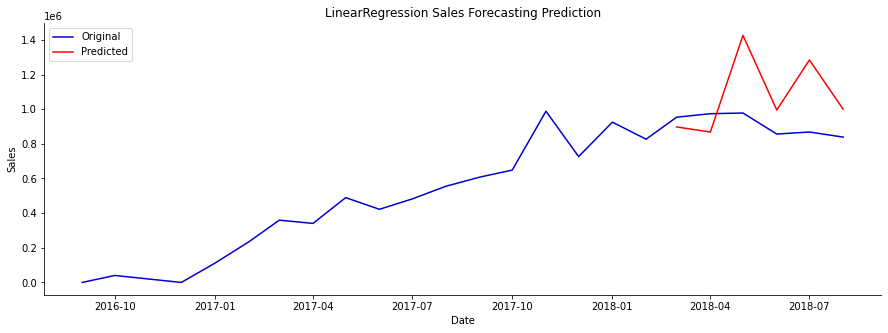

In [44]:
# run model
run_model(train, test, LinearRegression(), 'LinearRegression')

In [45]:
# lstm model
def lstm_model(train_data, test_data):

    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                    stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)

    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)

    get_scores(unscaled_df, original_df, 'LSTM')

    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
10/10 [==============================] - 2s 2ms/step - loss: 0.2992
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2900
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2810
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2730
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2661
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 0.2600
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2546
Epoch 8/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2498
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2454
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2414
Epoch 11/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2377
Epoch 12/200
10/10 [==============================] - 0s 2ms/step - loss: 0.2342
Epoch 13/200
10/10 [=================

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


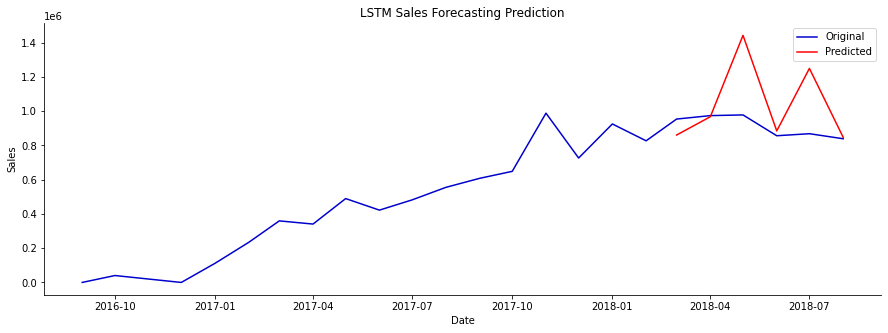

In [46]:
# run model
lstm_model(train, test)